[Tutorial](https://lightning.ai/docs/pytorch/stable/starter/introduction.html)

In [29]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning as L
from lightning.pytorch import Trainer, seed_everything
import os
import pandas as pd
from torchvision.io import read_image, decode_image
from torchvision.transforms.v2 import Normalize
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
SEED = 5
seed_everything(SEED, workers=True)

Seed set to 5


5

In [3]:
def dir_to_df(PATH:os.path)-> pd.DataFrame:
    data_dict = {"image_path":[],"label":[]}
    for label in os.listdir(PATH):
        if os.path.isdir(os.path.join(PATH,label)):
            image_path = [os.path.join(os.path.join(PATH,label),i) for i in os.listdir(os.path.join(PATH,label))]
            label_list = [label]*len(image_path)
            data_dict["image_path"].extend(image_path)
            data_dict["label"].extend(label_list)

    data_df = pd.DataFrame.from_dict(data_dict)
    return data_df

In [7]:
## Make a dataframe with the label
## Train
DATASET_PATH = os.path.join("..","dataset","nature_12K","inaturalist_12K")
TRAIN_PATH = os.path.join(DATASET_PATH,'train')
TEST_PATH = os.path.join(DATASET_PATH,'val')

train_df = dir_to_df(TRAIN_PATH)
test_df = dir_to_df(TEST_PATH)
class_mapping_dict = {j:i+1 for i,j in enumerate(test_df["label"].unique())}
train_df["label_id"] = train_df["label"].map(class_mapping_dict)
test_df["label_id"] = test_df["label"].map(class_mapping_dict)
## Randomize the dataframe
train_df = train_df.sample(frac=1.0)
test_df = test_df.sample(frac=1.0)

In [9]:
train_df.head()

,image_path,label,label_id
8087,..\dataset\nature_12K\inaturalist_12K\train\Pl...,Plantae,9
2658,..\dataset\nature_12K\inaturalist_12K\train\Ar...,Arachnida,3
5431,..\dataset\nature_12K\inaturalist_12K\train\In...,Insecta,6
5170,..\dataset\nature_12K\inaturalist_12K\train\In...,Insecta,6
649,..\dataset\nature_12K\inaturalist_12K\train\Am...,Amphibia,1


In [37]:
image_normalization = Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

class CustomImageDataset(Dataset):
    def __init__(self, dataset_df:pd.DataFrame, image_normalization:Normalize ):
        self.dataset_df = dataset_df
        self.image_normalization = image_normalization
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx:int):
        img_path = self.dataset_df.iloc[idx]["image_path"]#.values[0]
        image = decode_image(img_path, mode="RGB")
        image = self.image_normalization(image/image.max())

        label = self.dataset_df.iloc[idx]["label_id"]#.values[0]
        return image, label

In [38]:
train_dataset = CustomImageDataset(dataset_df = train_df, image_normalization = image_normalization)
X,y = train_dataset.__getitem__(4)

In [48]:
X.max()

tensor(2.6400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


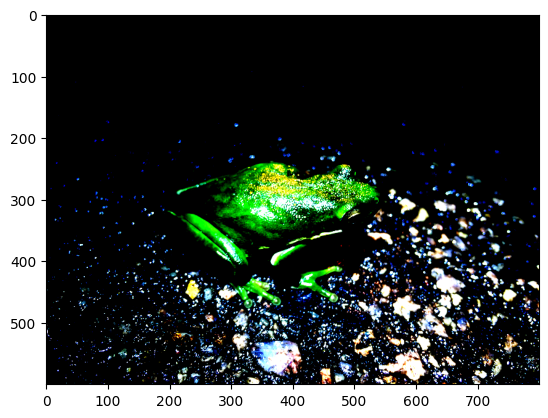

In [46]:
plt.imshow(X.permute(1,2,0))

In [3]:
# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

In [4]:
# define the LightningModule
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [5]:
# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)

In [6]:
# setup data
dataset = MNIST(os.getcwd(), download=True, transform=ToTensor())
train_loader = utils.data.DataLoader(dataset)

100%|██████████| 9.91M/9.91M [00:07<00:00, 1.34MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 117kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 789kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 754kB/s]


In [7]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(limit_train_batches=100, max_epochs=1)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 50.4 K | train
1 | decoder | Sequential | 51.2 K | train
-----------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
c:\Users\yuvar\miniconda3\envs\fastapi\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 100/100 [00:01<00:00, 51.45it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 100/100 [00:02<00:00, 49.33it/s, v_num=0]
